# The Amsterdam Resources for doing Computational Social Science
## Time series analysis with Python

(c) Joanna Strycharz, Damian Trilling, Nadine Strauß

Thank you for using our resources. If this template was useful for your analysis, please cite our paper on which this tutorial is based: Strycharz, J., Strauss, N., & Trilling, D. (2018). The role of media coverage in explaining stock market fluctuations: Insights for strategic financial communication. International Journal of Strategic Communication, 12(1), 67–85. doi:10.1080/1553118X.2017.1378220

The original tutorial can be found here: https://github.com/damian0604/bdaca/tree/master/ipynb

# What are we going to do?

In this tutorial, you learn how to estimate Vector Autoregression (VAR) models as described by Vliegenthart (2014). VAR analyses are appropriate when assessing relationships among variables in which the direction, duration or delay of effects is not clearly motivated by theory. VAR analyses consider both variables as endogenous.
This can be useful to study temporal dynamics of newspaper coverage. A typical workflow might include the use of regular expressions to select relevant articles and sentiment analysis, supervised machine learning, or topic modeling, to enrich the dataset. For this tutorial, we prepared a simple example dataset that contains basic information on media coverage about a company, and a second dataset that includes stock prices of that company.

The following steps will be undertaken in the tutorial to conduct the analysis: data will be loaded, adjusted and merged. Next, it will be aggreagted at a daily level. Finally, stationarity tests and possibly differencing of the time series will follow and subsequently, the VAR model will be constructed. 

The example we use is loosely based on an analysis presented in Strycharz, Strauß, & Trilling (2016).


## What are we going to use?

We will use the Python module pandas as a general framework for data aggregation and data analysis. For the VAR models, we are going to combine pandas with statsmodels. Before you start, make sure you have the most recent version of both. Most likely, you want to run something like this:

    pip3 install pandas --upgrade
    pip3 install numpy --upgrade
    pip3 install statsmodels --upgrade

If you want to learn more about how to use and install Python, you can read our general manual which is provided [here](https://github.com/damian0604/bdaca/blob/master/book/bd-aca_book.pdf). An alternative (probably quicker) solution is to install [Anaconda](https://www.continuum.io/downloads).

To learn more about data analysis using pandas, we recommend the book by McKinney (2012).

We'll also use an example dataset, which you can download here:
- [media.csv](media.csv)
- [stock.csv](stock.csv)


## References
McKinney, W. (2012). Python for data analysis. Sebastopol, CA: O’Reilly. ([free download](http://it-ebooks.info/book/1041/))

Strycharz, J., Strauß, N., & Trilling, D. (2016). Media coverage and share price volatility: Is it only attention that matters? *Manuscript submitted for presentation*

Vliegenthart, R. (2014). Moving up. Applying aggregate level time series analysis in the study of media coverage. *Quality & Quantity, 48*(5), 2427-2445.


### Let's get started!

First, we are going to import all neccessary modules. Also, we want to make sure that all plots we will make appear within this notebook:

In [67]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa as smtsa
from pandas.tseries.offsets import BDay

In [68]:
%matplotlib inline

## Loading, inspecting, and merging datasets

### Loading
We have two datasets: One with media data and one with stock exchange data. We will start by merging the two.
So, let's load our first dataset in a dataframe and inspect it.

In [69]:
media = pd.read_csv('media.csv')
print(media.columns)

Index(['id', 'length', 'positivity', 'negativity', 'pubdate_day',
       'pubdate_month', 'pubdate_year', 'pubdate_dayofweek', 'pubdate_weeknr'],
      dtype='object')


### Inspecting
Let's also have a look at the table. Each row represents one article about company X. For each article, we have a unique ID, the length of the article, two measures of sentiment (positivity and negativity), and the date on which it was published.

In [70]:
media

id  length  positivity  negativity  pubdate_day  \
0    569eba862d00594dd4c62efb    3261           2          -3            7   
1    569ebbbd2d00594dd4c6311b    1980           1          -3           10   
2    569ebc102d00594dd4c631a5    4068           2          -3           11   
3    569ebc852d00594dd4c6326c     720           1          -2           13   
4    569ebdf92d00594dd4c634ea    2278           2          -3           20   
5    569ebf392d00594dd4c63715    3956           3          -4           23   
6    569ec0882d00594dd4c639e5     670           3          -2           27   
7    569ec1082d00594dd4c63af5    2023           3          -3           29   
8    569ec14c2d00594dd4c63b73     812           1          -4           30   
9    569ec1812d00594dd4c63bd4     887           1          -2           30   
10   569f5cbd2d0059663a7bca00    2281           3          -3           17   
11   569f5cbd2d0059663a7bca65    2240           1          -3           20   
12   569f5cbd2d0059663a7bcac4    2149           3          -3           30   
13   569f5cc42d0059663a7bd4a2     568           1          -1            7   
14   569f5cc52d0059663a7bd53c     773           3          -2            8   
15   569f5cc62d0059663a7bd6c3    3590           3          -4            9   
16   569f5cc62d0059663a7bd6e7     364           1          -3            9   
17   569f5cc72d0059663a7bda75    1964           3          -2           13   
18   569f5cc82d0059663a7bdbc0    3102           3          -3           14   
19   569f5cc82d0059663a7bdbce     840           1          -2           14   
20   569f5cc82d0059663a7bdc05    3837           4          -3           14   
21   569f5cc82d0059663a7bdc69    1604           1          -3           14   
22   569f5cc92d0059663a7bdf11    1277           1          -2           16   
23   569f5cca2d0059663a7bdfe4    1487           3          -3           17   
24   569f5cca2d0059663a7bdfeb    1210           3          -3           17   
25   569f5cca2d0059663a7bdfef    3123           3          -3           17   
26   569f5cca2d0059663a7bdff7    1250           3          -2           17   
27   569f5cca2d0059663a7be01f    1644           3          -3           17   
28   569f5cca2d0059663a7be05a     776           2          -2           17   
29   569f5cca2d0059663a7be0a5    5223           4          -3           17   
..                        ...     ...         ...         ...          ...   
962  57250a892d00597c054634e1    2618           3          -3           15   
963  57250a8d2d00597c054634eb    5154           4          -3           15   
964  57250ba12d00597c0546373a    5183           3          -3           17   
965  57250bdb2d00597c054637a8    2067           3          -3           17   
966  57250c232d00597c05463846    8667           3          -3           18   
967  57250c2b2d00597c05463855    1611           5          -3           18   
968  57250cca2d00597c05463968     713           1          -2           19   
969  57250cce2d00597c05463974    1352           3          -2           19   
970  57250cdd2d00597c0546398f    2807           3          -3           19   
971  57250dbb2d00597c05463b17    3118           3          -3           21   
972  57250e262d00597c05463bfb    2784           4          -3           22   
973  57250e3d2d00597c05463c24    8485           3          -4           22   
974  57250e4d2d00597c05463c41    1146           4          -3           22   
975  57250e772d00597c05463ca2    1825           3          -2           22   
976  57250ec42d00597c05463d53    9699           3          -4           23   
977  57250ec82d00597c05463d5d    9699           3          -4           23   
978  57250ecf2d00597c05463d6d    1184           3          -3           23   
979  57250f542d00597c05463e47    5037           4          -3           24   
980  57250fd82d00597c05463f39    2606           3          -3           25   
981  572510ae2d00597c054640cd     331           1

We can get a even better overview of the dataset by using the methods .value_counts (to get a frequency table) or .describe (to get descriptive statistics)

In [71]:
media['pubdate_year'].value_counts(sort=False)

2014    418
2015    574
Name: pubdate_year, dtype: int64

In [72]:
media.describe()

length  positivity  negativity  pubdate_day  pubdate_month  \
count    992.000000  992.000000  992.000000   992.000000     992.000000   
mean    2652.804435    2.304435   -2.789315    15.268145       6.568548   
std     2408.886191    1.042033    0.797933     8.983373       3.529512   
min      104.000000    1.000000   -5.000000     1.000000       1.000000   
25%      906.000000    1.000000   -3.000000     7.000000       4.000000   
50%     1968.000000    2.000000   -3.000000    15.000000       6.000000   
75%     3686.000000    3.000000   -2.000000    22.250000      10.000000   
max    19912.000000    5.000000   -1.000000    31.000000      12.000000   

       pubdate_year  pubdate_dayofweek  pubdate_weeknr  
count    992.000000         992.000000      992.000000  
mean    2014.578629           2.405242       26.181452  
std        0.494028           1.625072       15.374614  
min     2014.000000           0.000000        1.000000  
25%     2014.000000           1.000000       14.000000  
50%     2015.000000           2.000000       24.000000  
75%     2015.000000           4.000000       41.000000  
max     2015.000000           6.000000       52.000000

### Dealing with dates

We saw that our dataset contained date information in different columns: one for month, day, and year of publication, respectively. However, that's not what we want. In order to work with our data, we need to
- get it into *one* column, formated as a datetime object, so that pandas understands the temporal order
- change the days of all Saturdays and Sundays to the next Monday (because stock exchanges are closed on the weekend)
- drop the unneccessary old date columns from the dataframe.

Most importantly, this enables us to use the new datetime object as an *index*: This means that pandas does not address each row by its row number, but by its date. Note that this has nothing to do with aggregating yet, there can be several rows with the same date. Using a datetime index makes it not only very easy to merge our dataset with other datasets that are indexed by date as well, but it also makes it possible to automatically make plots and analysis over time.

Luckily, all of this is very easy in pandas:

In [73]:
# We rename our columns, so that the to_datetime function which we use next recognizes which column contains what.
media.rename(columns={'pubdate_year':'year','pubdate_month':'month','pubdate_day':'day'},inplace=True)

# make new column called 'date' which contains a datetime object
media['date']=pd.to_datetime(media[['day','month','year']])
# convert to business days: Merge Saturday and Sunday with Monday
media['date']=media['date']+ BDay(0)
# drop old stuff
media=media.drop(['day','month','year','pubdate_dayofweek','pubdate_weeknr'],axis=1)

# index dataset by date (instead of by row number)
media.index=pd.DatetimeIndex(media['date'])

It's always a good idea to check whether everything looks like expected:

In [74]:
media

id  length  positivity  negativity  \
date                                                                   
2015-01-07  569eba862d00594dd4c62efb    3261           2          -3   
2015-01-12  569ebbbd2d00594dd4c6311b    1980           1          -3   
2015-01-12  569ebc102d00594dd4c631a5    4068           2          -3   
2015-01-13  569ebc852d00594dd4c6326c     720           1          -2   
2015-01-20  569ebdf92d00594dd4c634ea    2278           2          -3   
2015-01-23  569ebf392d00594dd4c63715    3956           3          -4   
2015-01-27  569ec0882d00594dd4c639e5     670           3          -2   
2015-01-29  569ec1082d00594dd4c63af5    2023           3          -3   
2015-01-30  569ec14c2d00594dd4c63b73     812           1          -4   
2015-01-30  569ec1812d00594dd4c63bd4     887           1          -2   
2014-01-17  569f5cbd2d0059663a7bca00    2281           3          -3   
2014-01-20  569f5cbd2d0059663a7bca65    2240           1          -3   
2014-01-30  569f5cbd2d0059663a7bcac4    2149           3          -3   
2014-01-07  569f5cc42d0059663a7bd4a2     568           1          -1   
2014-01-08  569f5cc52d0059663a7bd53c     773           3          -2   
2014-01-09  569f5cc62d0059663a7bd6c3    3590           3          -4   
2014-01-09  569f5cc62d0059663a7bd6e7     364           1          -3   
2014-01-13  569f5cc72d0059663a7bda75    1964           3          -2   
2014-01-14  569f5cc82d0059663a7bdbc0    3102           3          -3   
2014-01-14  569f5cc82d0059663a7bdbce     840           1          -2   
2014-01-14  569f5cc82d0059663a7bdc05    3837           4          -3   
2014-01-14  569f5cc82d0059663a7bdc69    1604           1          -3   
2014-01-16  569f5cc92d0059663a7bdf11    1277           1          -2   
2014-01-17  569f5cca2d0059663a7bdfe4    1487           3          -3   
2014-01-17  569f5cca2d0059663a7bdfeb    1210           3          -3   
2014-01-17  569f5cca2d0059663a7bdfef    3123           3          -3   
2014-01-17  569f5cca2d0059663a7bdff7    1250           3          -2   
2014-01-17  569f5cca2d0059663a7be01f    1644           3          -3   
2014-01-17  569f5cca2d0059663a7be05a     776           2          -2   
2014-01-17  569f5cca2d0059663a7be0a5    5223           4          -3   
...                              ...     ...         ...         ...   
2015-12-15  57250a892d00597c054634e1    2618           3          -3   
2015-12-15  57250a8d2d00597c054634eb    5154           4          -3   
2015-12-17  57250ba12d00597c0546373a    5183           3          -3   
2015-12-17  57250bdb2d00597c054637a8    2067           3          -3   
2015-12-18  57250c232d00597c05463846    8667           3          -3   
2015-12-18  57250c2b2d00597c05463855    1611           5          -3   
2015-12-21  57250cca2d00597c05463968     713           1          -2   
2015-12-21  57250cce2d00597c05463974    1352           3          -2   
2015-12-21  57250cdd2d00597c0546398f    2807           3          -3   
2015-12-21  57250dbb2d00597c05463b17    3118           3          -3   
2015-12-22  57250e262d00597c05463bfb    2784           4          -3   
2015-12-22  57250e3d2d00597c05463c24    8485           3          -4   
2015-12-22  57250e4d2d00597c05463c41    1146           4          -3   
2015-12-22  57250e772d00597c05463ca2    1825           3          -2   
2015-12-23  57250ec42d00597c05463d53    9699           3          -4   
2015-12-23  57250ec82d00597c05463d5d    9699           3          -4   
2015-12-23  57250ecf2d00597c05463d6d    1184           3          -3   
2015-12-24  57250f542d00597c05463e47    5037           4          -3   
2015-12-25  57250fd82d00597c05463f39    2606           3          -3   
2015-12-28  572510ae2d00597c054640cd     331           1          -3   
2015-12-28  572510ae2d00597c054640cf    1282           2          -2   
2015-12-28  572510af2d00597c054640d0    1282           2          -2   
2015-12-28  572510cf2d00597c05464117     890           1          -3   
20

### Aggregating
We want to aggregate per day. After all, our unit of analysis will become the day, not the article. We will use a .sum() function for that, basically adding up everything that happens on the same day. If there are three article on a given day, one of length 420, one of length 550, and one of length 530, then the aggretgated length for that day will be 420 + 550 + 530 = 1500. The same holds true for positvity and negativity.  
However, for our first analysis, we simply want to know how many articles were published, so we'll just create a variable that is 1 for every case. After aggregation, our new variable "visibility" will then be 1 + 1 + 1 = 3 for that day.
Of course, for other analyses, we could use other aggregation functions, for example .mean()

In [75]:
# make new variable to be able to count articles
media['visibility']=1

# aggregate
media_day=media.groupby(by=['date']).sum()

Let's see if all of that makes sense and let's make some plots over time. As explained above, because our dataframe is indexed by date, we don't have to take care of that any more and can just plot the columns of the dataset we are interested in.

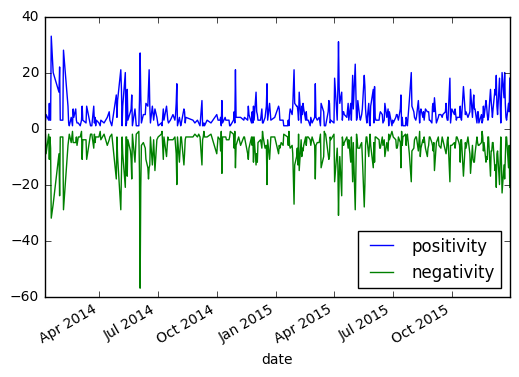

In [76]:
media_day[['positivity','negativity']].plot() # plot

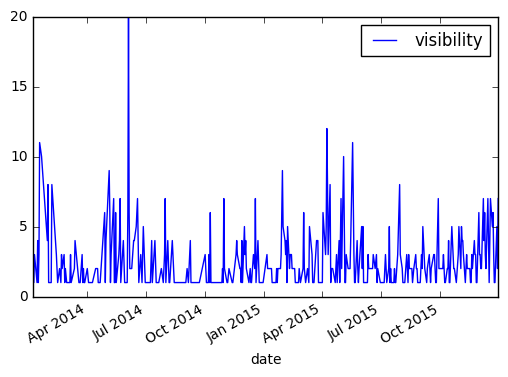

In [77]:
media_day[['visibility']].plot()

### Merge with stock dataset

Now that we have prepared everything, we can open our stock dataset, make sure that it is also indexed by day (luckily, its date is already saved in a format that can automatically be transformed to a datetime object, so we don't have to mess around with different variables here).

In [78]:
stock=pd.read_csv('stock.csv',sep=',')
stock['date']=pd.to_datetime(stock['Date'])
stock.index=pd.DatetimeIndex(stock['date'])
stock=stock.drop(['Date','date'],axis=1)

Again, it's always a goot idea to check whether the dataset looks like expected:

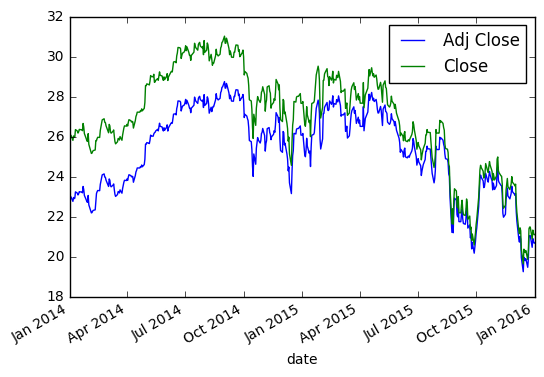

In [79]:
stock[['Adj Close','Close']].plot()

Now, we can merge the two dataset with the .join() method. The .fillna(0) method replaces missing values with 0, which makes sense in our case because if on a given day there is no information on media coverage (no negativity, no positivity, etc.), then the reason is not that we do not know these attributes, but simply that there was no article published, which should be reflected in the data as 0.

In [80]:
mediastock = stock.join(media_day,how='left').fillna(0)

In [81]:
mediastock[:5]

Open    High     Low   Close   Volume  Adj Close   length  \
date                                                                      
2016-01-01  21.095  21.095  21.095  21.095        0    20.6742      0.0   
2015-12-31  21.135  21.140  20.915  21.095  1680700    20.6742      0.0   
2015-12-30  21.330  21.375  21.110  21.185  5476800    20.7624  23717.0   
2015-12-29  21.000  21.410  20.995  21.325  6261600    20.8996   6795.0   
2015-12-28  21.440  21.450  20.705  20.880  5168400    20.4635   9348.0   

            positivity  negativity  visibility  
date                                            
2016-01-01         0.0         0.0         0.0  
2015-12-31         0.0         0.0         0.0  
2015-12-30        18.0       -21.0         7.0  
2015-12-29         6.0        -6.0         2.0  
2015-12-28         9.0       -14.0         5.0

## Time to start the VAR analysis!

### Stationarity
The first thing you have to do is checking for stationarity as VAR requires all time series to be stationary. To test for this, Dickey-Fuller (DF) tests are conducted for all series under investigation. If the tests do not reject the null hypothesis that assumes time series to be non-stationary, the series need to be differenced to achieve stationarity of the series. After differencing, the DF tests usually yield significant results, meaning we have reached stationary of the series.
Let us first look into the variable we are most interested in, the stock prices. You could run
help(sm.tsa.stattools.adfuller)
to learn more about every detail, but for now, it might be enough to know that the first line gives you the Z-score, whole the second returned value is the p-value.

In [82]:
sm.tsa.stattools.adfuller(mediastock['Adj Close'])

(-2.5515110941521715,
 0.10343866512202399,
 1,
 521,
 {'1%': -3.4429638415440995,
  '10%': -2.5697331315829222,
  '5%': -2.8671034821276349},
 404.34278073538189)

We see that p=.10, which is not significant. Therefore, we need to *difference* the series. 

But lets first check the other variables, and let's write a nice loop that prints out only the p-values in a clear way.

In [83]:
mediavars=['positivity','negativity','visibility']
for m in mediavars:
    print(m,sm.tsa.stattools.adfuller(mediastock[m])[1])

positivity 2.84712704019e-30
negativity 3.83303299318e-30
visibility 5.00238766254e-30


These series are clearly stationary, so usually we would NOT need to difference. But because *all* series have to be stationary, and one series (the stock price) is not, we have to differentiate anyway.
To avoid any confusion (and because our dataset is so small that we don't care about the extra memory here), we create a new dataframe for this:

In [84]:
mediastockdiff=mediastock
mediastockdiff['Adj Close']=mediastockdiff['Adj Close'].diff()
mediastockdiff['visibility']=mediastockdiff['visibility'].diff()
mediastockdiff['positivity']=mediastockdiff['positivity'].diff()
mediastockdiff['negativity']=mediastockdiff['negativity'].diff()

# Of course, it would have been more efficient to write a loop again for this, 
# but there needs some room for you to improve this template ;-)

Because of differentiation, the first row of the differentiated values now is NaN ('not a number', missing). Make sure to take that into account in future analysis.

In [85]:
mediastockdiff[:5]

Open    High     Low   Close   Volume  Adj Close   length  \
date                                                                      
2016-01-01  21.095  21.095  21.095  21.095        0        NaN      0.0   
2015-12-31  21.135  21.140  20.915  21.095  1680700     0.0000      0.0   
2015-12-30  21.330  21.375  21.110  21.185  5476800     0.0882  23717.0   
2015-12-29  21.000  21.410  20.995  21.325  6261600     0.1372   6795.0   
2015-12-28  21.440  21.450  20.705  20.880  5168400    -0.4361   9348.0   

            positivity  negativity  visibility  
date                                            
2016-01-01         NaN         NaN         NaN  
2015-12-31         0.0         0.0         0.0  
2015-12-30        18.0       -21.0         7.0  
2015-12-29       -12.0        15.0        -5.0  
2015-12-28         3.0        -8.0         3.0

In the particular domain of this dataset (predicting stock volatility), it seems to be common to not predict the direction of change, but only the absolute value of the change, irrespective of whether it is going up or down. So, that's what we're going to do -- but feel free to try out what happens if you use the original value instead!

In [86]:
mediastockdiff['Adj Close_abs']=mediastockdiff['Adj Close'].abs()

To be absolutely sure, let's check again for stationarity. 

In [87]:
# .ix[2:] slices the dataframe (in effect leaves away row number 0 and 1 which is NAN now b/c of differentiation)

allvars=['Adj Close','Adj Close_abs','positivity','negativity','visibility']
for m in allvars:
    print(m, sm.tsa.stattools.adfuller(mediastockdiff.ix[2:][m])[1])

Adj Close 0.0
Adj Close_abs 1.88233339063e-16
positivity 7.32004249564e-16
negativity 5.50684214047e-17
visibility 2.72988524093e-17


Great! Everything looks good now, all series are stationary.

### Lag selection

In the next step, the number of lags of the variables in the model needs to be specified. This decision should be mainly triggered by theory. Furthermore, you can look at the fit-statistics such as the AIC and BIC to choose the number of lags that suggests the best model fit. The asterisks in the output of the selection-order criteria usually indicate the optimal number of lags for the model.

In [88]:
dfsub = mediastockdiff.ix[1:][['visibility','Adj Close_abs']]

model = sm.tsa.VAR(dfsub)
model.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0       -0.7696      -0.7529       0.4632      -0.7631
1       -0.9951      -0.9450       0.3697      -0.9754
2        -1.079      -0.9960       0.3398       -1.047
3        -1.118      -1.001*       0.3269       -1.072
4        -1.151       -1.001       0.3163      -1.092*
5        -1.161      -0.9772       0.3133       -1.089
6        -1.169      -0.9519       0.3108       -1.084
7        -1.180      -0.9297       0.3073       -1.082
8        -1.185      -0.9015       0.3057       -1.074
9        -1.193      -0.8765       0.3032       -1.069
10       -1.185      -0.8343       0.3059       -1.047
11       -1.186      -0.8022       0.3055       -1.035
12       -1.188      -0.7705       0.3050       -1.024
13       -1.204      -0.7540       0.2999       -1.028
14      -1.205*      -0.7208      0.2999*       -1.015
15       -

{'aic': 14, 'bic': 3, 'fpe': 14, 'hqic': 4}

Based on the AIC, we conclude that 14 lags are most appropriate.

### Estimating a VAR model

We now can estimate a VAR model with 14 lags:
To do so, again, a subset of the data is created to use only the variables of interest for this model. Also, remember to leave away row number 0 ([1:]) as it contains NAN after differencing. 

In [89]:
dfsub = mediastockdiff.ix[1:][['visibility','Adj Close_abs']]
model = sm.tsa.VAR(dfsub)
results = model.fit(14)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 02, Nov, 2016
Time:                     21:13:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.721899
Nobs:                     508.000    HQIC:                  -1.01550
Log likelihood:          -1077.60    FPE:                   0.299794
AIC:                     -1.20491    Det(Omega_mle):        0.268289
--------------------------------------------------------------------
Results for equation visibility
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.325729         0.238591            1.365           0.173
L1.visibility            -0.719514         0.045303          -15.882           0.000
L1.Adj Close_abs         -0.128678     

The next thing we want to do is to test the Granger Causaility to find out if visibility leads to market volatility or the other way around.

In [90]:
results.test_causality('Adj Close_abs',['visibility'])

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.745440         1.702102            0.042  (14, 958)
H_0: ['visibility'] do not Granger-cause Adj Close_abs
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 1.7021015432469633,
 'df': (14, 958),
 'pvalue': 0.042373784148657924,
 'signif': 0.05,
 'statistic': 1.7454396889704096}

It seems that visibility Granger-causes price volatility, as we reject H0.

In [91]:
results.test_causality('visibility','Adj Close_abs')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         0.680673         1.702102            0.795  (14, 958)
H_0: ['Adj Close_abs'] do not Granger-cause visibility
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.7021015432469633,
 'df': (14, 958),
 'pvalue': 0.79487167664391412,
 'signif': 0.05,
 'statistic': 0.68067331226199224}

We do not find an effect from volatility on visibility, because we cannot reject H0. This is pretty much what we expected, as we expected that stock exchange prices react to media coverage, rather than media coverage reacting to stock volatility.

However, all of this is rather hard to see on the plots:

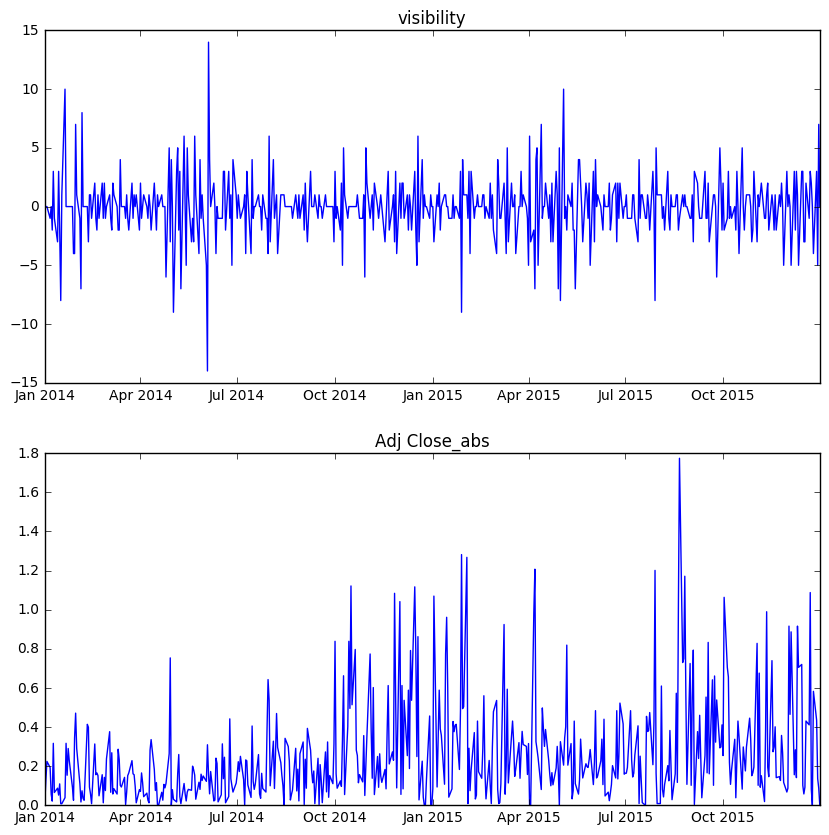

In [92]:
results.plot()

The next question to answer is how long the effects last. This can be done by plotting the impulse response functions for the appropriate number of lags. 
The *cumulative impulse response function* (CIRF) summarizes the additional increase of the dependent variable after there is a one-unit increase in the independent variable. For example, an additional one-unit increase of X results in a significant increase(decrease) of .075 points of variable Y.

/usr/local/lib/python3.5/dist-packages/numpy/lib/twodim_base.py:233: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m = zeros((N, M), dtype=dtype)
/usr/local/lib/python3.5/dist-packages/numpy/lib/twodim_base.py:240: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m[:M-k].flat[i::M+1] = 1


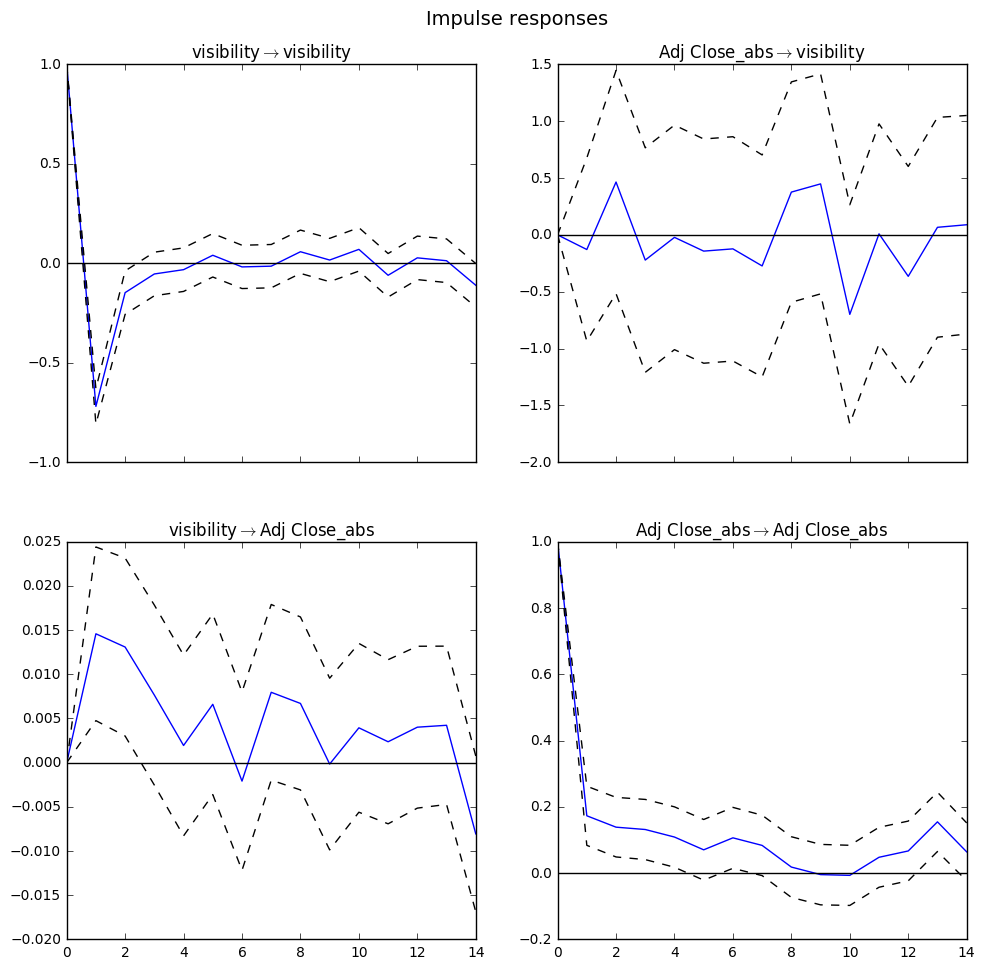

In [93]:
irf = results.irf(14)
irf.plot()

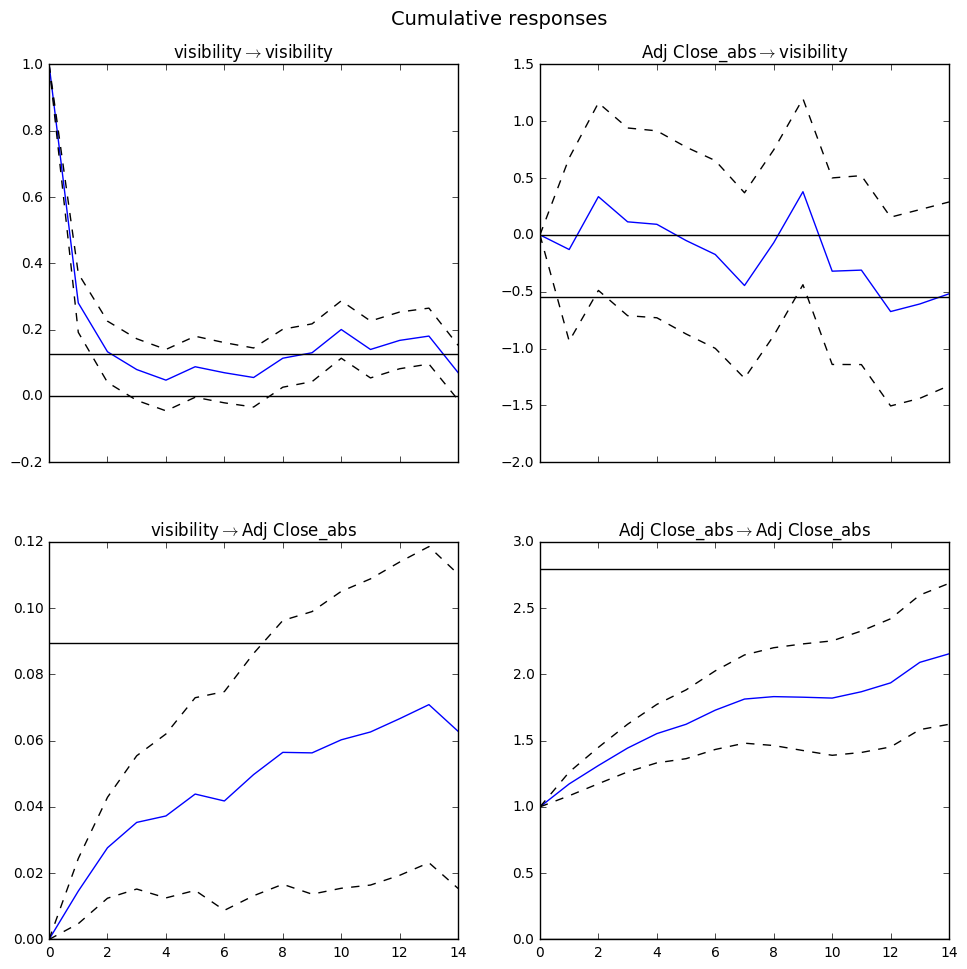

In [94]:
irf.plot_cum_effects()

As we have concluded that media attention Granger causes stock price volatility, the bottom left graphs are most interesting for us.
To identify the exact CIRF value have to investigate the values of CIRF.

In [95]:
irf.cum_effects

array([[[ 1.        ,  0.        ],
        [ 0.        ,  1.        ]],

       [[ 0.28048557, -0.12867787],
        [ 0.0145817 ,  1.17311504]],

       [[ 0.13305705,  0.33648917],
        [ 0.027665  ,  1.31187104]],

       [[ 0.07945376,  0.11498079],
        [ 0.03531454,  1.44357964]],

       [[ 0.04749218,  0.09323279],
        [ 0.03725976,  1.5525341 ]],

       [[ 0.08792551, -0.04948877],
        [ 0.04386472,  1.62293381]],

       [[ 0.06984184, -0.17238164],
        [ 0.04177942,  1.7294881 ]],

       [[ 0.05546165, -0.4454798 ],
        [ 0.04974236,  1.81321092]],

       [[ 0.11366068, -0.06882544],
        [ 0.05644465,  1.83159453]],

       [[ 0.1301192 ,  0.38004698],
        [ 0.05628911,  1.82716956]],

       [[ 0.2002238 , -0.31925599],
        [ 0.06023265,  1.8205212 ]],

       [[ 0.14005431, -0.30992317],
        [ 0.06260012,  1.86842338]],

       [[ 0.16748297, -0.67452881],
        [ 0.06661536,  1.93540898]],

       [[ 0.18042874, -0.60776999],
  

In [96]:
irf.cum_effect_stderr()

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.04530319,  0.41128177],
        [ 0.00501322,  0.04551215]],

       [[ 0.04714148,  0.4209526 ],
        [ 0.00776845,  0.0699251 ]],

       [[ 0.04739927,  0.42141438],
        [ 0.01025895,  0.0917679 ]],

       [[ 0.04724167,  0.41960847],
        [ 0.01261818,  0.11254497]],

       [[ 0.04696843,  0.41955795],
        [ 0.01483129,  0.13236209]],

       [[ 0.04633971,  0.42155786],
        [ 0.01683626,  0.15130477]],

       [[ 0.04544735,  0.41640578],
        [ 0.0186532 ,  0.16981382]],

       [[ 0.04461496,  0.41716871],
        [ 0.02030445,  0.18820762]],

       [[ 0.04447911,  0.41765417],
        [ 0.0217509 ,  0.20517853]],

       [[ 0.04419034,  0.41874189],
        [ 0.022853  ,  0.22016744]],

       [[ 0.04382003,  0.42415739],
        [ 0.02356775,  0.23371871]],

       [[ 0.04365064,  0.4238062 ],
        [ 0.02411533,  0.24663573]],

       [[ 0.04302461,  0.42365762],
  

Similarly to the graph, we are interested in the influence of media attention on stock price volatility. We also want to know the *cummulative effect* - effect after a certain number of lags. Thereofre, we need to look at the last four items in the list, and more specifically the bottom left number. We can conclude that an additional one-unit increase of media attention (one additional article published) results in a significant increase of .063 points of stock volatility.

To conclude if the CIRF is stable we investigate the confidnece intervals. We can see them in the graph above and calculate them from the standard error of the CIRF.

Next, we compute the *forecast error variance* (FEV), which is a good indicator to show how much of the movement of
one variable is attributed by shocks of its own past and to what extent by shocks of the other variables. The method can show how much variation of one variable can be explained by its own past or by another variable. 
Similarly to the CIRF, the appropriate number of lags is selected for this analysis. 

In [97]:
fevd = results.fevd(14)
fevd.summary()

FEVD for visibility
      visibility  Adj Close_abs
0       1.000000       0.000000
1       0.999866       0.000134
2       0.998151       0.001849
3       0.997766       0.002234
4       0.997764       0.002236
5       0.997606       0.002394
6       0.997487       0.002513
7       0.996900       0.003100
8       0.995793       0.004207
9       0.994217       0.005783
10      0.990442       0.009558
11      0.990463       0.009537
12      0.989445       0.010555
13      0.989411       0.010589

FEVD for Adj Close_abs
      visibility  Adj Close_abs
0       0.000188       0.999812
1       0.016176       0.983824
2       0.028221       0.971779
3       0.031775       0.968225
4       0.031662       0.968338
5       0.034498       0.965502
6       0.034504       0.965496
7       0.038518       0.961482
8       0.041549       0.958451
9       0.041550       0.958450
10      0.042612       0.957388
11      0.042884       0.957116
12      0.043750       0.956250
13      0.043918       0.956

Looking at the "FEVD for Adj Close_abs" value at lag 14 we can conclude that 4.39% of variation in stock price volatility can be explaied by media attenion within two weeks.

To conclude that the constructed VAR model is robust several tests need to be conducted.

First, before interpreting the results of the VAR analysis, one has to test the residuals of the time series for non-autocorrelation. This needs to be done in order to be sure that the series adequately reflects the series¹ past. The null hypothesis of the Portmonteau (Q) test assumes the residuals to be white noise. Hence, we aim for accepting the null hypothesis (look for non-significant result). If this is not achieved, it can be considered to add additional lags to the model (however, keep in mind that the number of lags should be rather kept low in order to prevent spurious relations).

The comand below returns residuals values needed in robustness checks. You can use them in later tests.

In [98]:
results.resid

visibility  Adj Close_abs
date                                 
2015-12-11   -1.458997       0.274699
2015-12-10    0.255809       0.587528
2015-12-09    1.734854      -0.309604
2015-12-08   -0.286063      -0.077404
2015-12-07    2.595280      -0.199739
2015-12-04   -2.121594       0.489160
2015-12-03   -0.532777      -0.111452
2015-12-02   -0.283896       0.552725
2015-12-01   -1.127898      -0.257389
2015-11-30    1.789499      -0.172119
2015-11-27   -3.532149      -0.120427
2015-11-26   -1.699452      -0.050793
2015-11-25    0.783562       0.033116
2015-11-24    0.617430      -0.140067
2015-11-23   -0.282545      -0.207914
2015-11-20   -1.172844       0.001074
2015-11-19    0.027023       0.223211
2015-11-18   -1.908537       0.039023
2015-11-17   -0.832390      -0.018100
2015-11-16   -0.446296       0.402918
2015-11-13   -2.175387      -0.244080
2015-11-12   -0.186921      -0.023625
2015-11-11    0.555292       0.776095
2015-11-10   -0.042271       0.034975
2015-11-09   -2.081731      -0.383750
2015-11-06    1.158300      -0.138506
2015-11-05    2.004576      -0.145917
2015-11-04    1.236422       0.487016
2015-11-03    2.577615      -0.220486
2015-11-02   -0.634874       0.461445
...                ...            ...
2014-02-11   -1.744310       0.195368
2014-02-10   -1.383163       0.207604
2014-02-07   -1.430267      -0.185634
2014-02-06   -1.139678      -0.109387
2014-02-05    6.531670      -0.073603
2014-02-04   -2.159298      -0.175133
2014-02-03   -1.765044      -0.101716
2014-01-31    0.085935       0.145753
2014-01-30    6.682872       0.326059
2014-01-29    0.012924      -0.030231
2014-01-28   -2.413978      -0.206092
2014-01-27   -1.274623      -0.159116
2014-01-24   -1.184810       0.056960
2014-01-23   -1.154779       0.115939
2014-01-22   -1.752879      -0.086264
2014-01-21   -0.744648       0.108470
2014-01-20    8.182050      -0.177659
2014-01-17    6.049883      -0.231083
2014-01-16   -1.570992      -0.222032
2014-01-15   -2.159986      -0.164435
2014-01-14    2.458425      -0.135448
2014-01-13   -1.868415      -0.136044
2014-01-10   -1.624310       0.038361
2014-01-09    1.215631       0.255396
2014-01-08   -1.798663      -0.253722
2014-01-07   -1.445793      -0.142605
2014-01-06   -2.659654       0.035242
2014-01-03   -1.950901       0.042381
2014-01-02   -2.280994      -0.069849
2014-01-01   -2.579103      -0.096819

[508 rows x 2 columns]

We now run the Portmonteau (Q) test for both variables in the model. The usual number of 20 lags is selected for this test.

In [99]:
r=sm.stats.diagnostic.acorr_ljungbox(results.resid['Adj Close_abs'],lags=20)
i=0
for e in zip(r[0],r[1]):
    i+=1
    print('lag {}\t Ljung Box test: {}\tp = {}'.format(i,e[0],e[1]))

lag 1	 Ljung Box test: 0.009909034698841706	p = 0.9207062476836734
lag 2	 Ljung Box test: 0.12721383702126202	p = 0.9383737844094868
lag 3	 Ljung Box test: 0.15256866803995	p = 0.984856517405008
lag 4	 Ljung Box test: 0.15256964710653118	p = 0.9972341411176813
lag 5	 Ljung Box test: 0.16305375218840387	p = 0.9994611708931804
lag 6	 Ljung Box test: 0.25452455297252913	p = 0.9996876592497317
lag 7	 Ljung Box test: 0.5301900329504086	p = 0.999328257171756
lag 8	 Ljung Box test: 1.429404456448766	p = 0.9938190228496728
lag 9	 Ljung Box test: 1.5536609204377139	p = 0.9967287573967166
lag 10	 Ljung Box test: 1.7705995279596038	p = 0.9978151688997599
lag 11	 Ljung Box test: 1.8013457398128203	p = 0.9990813874881178
lag 12	 Ljung Box test: 1.8667759905031194	p = 0.9995844447950801
lag 13	 Ljung Box test: 1.8667811582301488	p = 0.9998470103942607
lag 14	 Ljung Box test: 2.151943428656646	p = 0.9998698258730293
lag 15	 Ljung Box test: 3.3755981930112737	p = 0.9991714911676655
lag 16	 Ljung Box t

In the example above, we took some effort to print the results nicely. That's nice, but not neccessary. Let's do the same test vor the visibility variable without pretty-printing: (the first list of numbers contain the test statistics, the second the p values)

In [100]:
sm.stats.diagnostic.acorr_ljungbox(results.resid['visibility'],lags=20)

(array([  8.06018509e-04,   1.74741063e-01,   1.75157762e-01,
          2.49424859e-01,   3.75438828e-01,   3.77061001e-01,
          8.11909051e-01,   9.00679512e-01,   1.35328095e+00,
          1.54815906e+00,   2.04475197e+00,   2.23157454e+00,
          2.72095709e+00,   4.07805398e+00,   5.47591694e+00,
          6.42605681e+00,   1.32464594e+01,   1.34991814e+01,
          1.45796095e+01,   1.53209909e+01]),
 array([ 0.97735073,  0.9163375 ,  0.98149639,  0.99284071,  0.99597918,
         0.99902976,  0.99732051,  0.99880135,  0.99809591,  0.99877737,
         0.99833236,  0.99895961,  0.99876785,  0.99497809,  0.98727247,
         0.9828053 ,  0.7195371 ,  0.76110681,  0.748916  ,  0.75775525]))

Test for autocorrelation indicates that residuals morror white noise (at 20th lang, absolute closing price: 6.87, ns; media attenton: 15.32, ns)

Next, the Portmonteau (Q) test is exercised again, nut now by looking at the squared residuals of the series. The null hypothesis is the same as above. If we have to reject the null-hypothesis, this means we have to deal with heteroscedastic data. In other words, the variability of the residuals of all the stock market data is not equally distributed over time, but dependent on the time of measurement. To overcome this problem, one can either look for more sophisticated time series models (ARCH), or taking logarithmic values of the series. If taking logarithmic values is still not solving the problem, one should report this in the results section and report the results with caution.

To perform the next test we first need to create a list with squared residuals for the variables.

In [101]:
# HETEROSCEDASTICITY
sres_adj_close=[]
for line in results.resid['Adj Close_abs']:
    r_s=line*line
    #print(r_s)
    sres_adj_close.append(r_s)

In [102]:
sm.stats.diagnostic.acorr_ljungbox(sres_adj_close,lags=20)

(array([  1.43442224,   8.22674035,  35.26969798,  35.27257456,
         36.09028323,  36.64674341,  37.21772496,  37.22792873,
         37.97518371,  38.44129463,  39.28996976,  39.64562894,
         43.28488208,  44.77393331,  46.20838018,  46.85687674,
         63.44175708,  63.75254817,  63.94313348,  70.34074264]),
 array([  2.31044080e-01,   1.63525705e-02,   1.06844298e-07,
          4.08335510e-07,   9.11121339e-07,   2.06327990e-06,
          4.26555947e-06,   1.04493828e-05,   1.76109568e-05,
          3.17915425e-05,   4.72868083e-05,   8.23237114e-05,
          4.02918279e-05,   4.43865474e-05,   4.92614665e-05,
          7.16878356e-05,   2.81083292e-07,   4.99513371e-07,
          9.05776337e-07,   1.60222512e-07]))

In [103]:
sres_aantal=[]
for line in results.resid['visibility']:
    r_s=line*line
    sres_aantal.append(r_s)

In [104]:
sm.stats.diagnostic.acorr_ljungbox(sres_aantal,lags=20)

(array([  3.43198235,   4.89807865,   5.61552127,   5.69303952,
          6.7631123 ,   6.77653363,   7.02345153,   7.57127944,
          8.87771534,  13.22007824,  13.22007825,  16.87046793,
         17.32307556,  17.56335   ,  19.7387624 ,  19.76959372,
         24.58911899,  25.43803526,  25.52146006,  25.68735034]),
 array([ 0.0639453 ,  0.08637653,  0.13189013,  0.22327502,  0.23886243,
         0.34200866,  0.42644219,  0.47642721,  0.44863797,  0.21162601,
         0.27918496,  0.15453519,  0.18495269,  0.22739715,  0.18218476,
         0.23077781,  0.10429151,  0.11331838,  0.14408406,  0.17638778]))

We cannot reject the null hypothesis for the absolute closing price, which means that for this variable we can observe heteroscedasticity. However, as it is a common phenomenon for stock maret data thus no additional transformations are necessary.  

The final test - the VAR stability test - checks the eigenvalue stability condition after estimating the VAR model. The modulus of each eigenvalue has to be less than 1 so that the VAR model can be considered stable. If the VAR model is considered stable, we can interpret the CIRF and FEVD as outlined above.

In [105]:
smtsa.vector_ar.var_model.VARProcess.is_stable(results)

True

The returned value 'True' allows us to coclude that the model is stable. 

# TONE

Now it's your turn! There are some other variables in the dataset to play with, for example positivity and negativity. You might also think of combining them into some general measure of tone or of absolute emotionality. Good luck!